In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from oodeel.methods.base import OODBaseDetector
import numpy as np
from torchvision.transforms.functional import to_pil_image, resized_crop, to_tensor
from xplique.concepts import CraftTorch as Craft
from xplique.concepts import DisplayImportancesOrder
import torch.nn as nn
from sklearn.decomposition import NMF
import cv2
import matplotlib.pyplot as plt
import torchvision
from sklearn.neighbors import NearestNeighbors
from xplique.attributions.global_sensitivity_analysis import (HaltonSequenceRS, JansenEstimator)


class NMF_CONCEPTS_VIZ(OODBaseDetector):
    def __init__(self, model=None, n_components=10, n_neighbors=20, percentage_of_images=0.1, distance="euclidean", separate_classes=[6], crop_size=64, slide_size=6):
        super().__init__()
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.percentage_of_images = percentage_of_images
        self.distance = distance
        self.NMF = NMF(n_components=self.n_components, init='random', random_state=42, max_iter=1000)
        self.nmf_models = {}  # Dictionary to store NMF models and U, V matrices
        self.crop_size = crop_size
        self.slide_size = slide_size
        self.n_designs = 32
        self.separate_classes = separate_classes or []  # List of classes to separate
        self.separated_class_images = {}  # Dictionary to store images by class
        self.model = model
        self.size_w = 224
        self.size_h = 224
        self.dataset_length = 0
        self.reconstruction_errors = {}

        # print all the necessary info about the class
        print(f"n_components: {self.n_components}")
        print(f"n_neighbors: {self.n_neighbors}")
        print(f"percentage_of_images: {self.percentage_of_images}")
        print(f"distance: {self.distance}")
        print(f"crop_size: {self.crop_size}")
        print(f"slide_size: {self.slide_size}")
        print(f"separate_classes: {self.separate_classes}")

    
    # function to seperated images by class using a dictionary
    def _separate_images_by_class(self, dataset):
        for image, label in dataset:
            label = label.item()
            if label in self.separate_classes:
                if label not in self.separated_class_images:
                    self.separated_class_images[label] = []
                self.separated_class_images[label].append(image.squeeze(0))

        self.original_separated_class_images = self.separated_class_images.copy()

    def _extract_patches(self, image_tensor):
        # Ensure the input is a PyTorch tensor of shape (3, 224, 224)
        # assert image_tensor.shape == (3, 224, 224) or image_tensor.shape == (1, 3, ), "Input tensor must have shape (3, 224, 224)"
        
        # Convert to PIL Image
        if len(image_tensor.shape) == 4:
            image_tensor = image_tensor.squeeze(0)
        image = to_pil_image(image_tensor)
        patches = []

        # Define crop size
        crop_size = self.crop_size

        # Calculate the sliding factor (step size)
        step_size = (224 - crop_size) // self.slide_size  # 6 steps for 7 crops (224 - 64) / 6

        # Extract and resize patches
        for i in range(self.slide_size + 1):
            for j in range(self.slide_size + 1):
                top = i * step_size
                left = j * step_size
                # Crop the patch
                patch = resized_crop(image, top, left, crop_size, crop_size, (224, 224))
                # Convert back to tensor and add to list
                patches.append(to_tensor(patch))

        return patches

    def classes_images_to_patches(self):
        for label, images in self.separated_class_images.items():
            all_patches = []
            for image in images:
                # Divide each image into 7x7 patches and resize
                patches = self._extract_patches(image)
                all_patches.extend(patches)
            # Replace original images with their patches
            self.separated_class_images[label] = all_patches
            print(f"Class {label} has {len(self.separated_class_images[label])} images with shape {self.separated_class_images[label][0].shape}")

    def preprocess(self, image):
        transforms = torchvision.transforms.Compose([
                torchvision.models.ResNet50_Weights.IMAGENET1K_V1.transforms()
            ])
        
        return transforms(image)

    def _fit_to_dataset(self, fit_dataset):
        # Divide the model into two parts: g and h
        self.model.to("cuda:1")
        self.g = nn.Sequential(*(list(self.model.children())[:-1]))  # Input to penultimate layer
        self.h = nn.Sequential(*(list(self.model.children())[-1:]))  # Penultimate layer to logits
        self.dataset_length = len(fit_dataset.dataset)
        # training_features = self.feature_extractor.predict(fit_dataset)
        # # prendre les logits 
        # self.labels_train = self.op.convert_to_numpy(training_features[1]["labels"])
        # Separate images by class using a dictionary
        self._separate_images_by_class(fit_dataset)

        # Process and transform the images of every class into patches
        self.classes_images_to_patches()

        # Run NMF and concepts for all classes
        for label, images in self.separated_class_images.items():
            images_fit = [(self.preprocess(image), label) for image in images]
            self._process_class(label, images_fit)
            print(f"Finished processing class {label}")

        # self.show_concepts_per_class(self.separate_classes[0])
    
    def _process_class(self, label, images):
        print(f"-------------- processing class {label} --------------------")
        # Transform the images to tensor
        # Get a data loader for the images of the class
        class_dataset = DataLoader(images, batch_size=128, shuffle=False)
        # Extract features from the penultimate layer
        features = self.feature_extractor.predict(class_dataset)
        self.labels_train = self.op.convert_to_numpy(features[1]["labels"])
        features= self.op.convert_to_numpy(features[0][0])
        # Flatten all the features in one dimension (batch, features)
        features = features.reshape(features.shape[0], -1)
        print("The shape of the features: ", features.shape)

        print("Calculating NMF .......")
        # Build the NMF algorithm
        nmf = NMF(n_components=self.n_components, init='random', random_state=42, max_iter=1000)
        U = nmf.fit_transform(features)    
        V = nmf.components_
        print(" NMF completed ........")

        # calculate the reconstruction error

        print("finding top activated images for each concept .......")
        top_activated_images = {}
        top_activated_images_features = {}
        for concept in range(self.n_components):
            U_concept = U[:, concept]
            top_percentage_len = 10  # int(len(U_concept) * self.percentage_of_images)
            sorting_indices = np.argsort(U_concept)[::-1][:top_percentage_len]
            U_top = U[sorting_indices]
            # Create a grid to show the top 5 images that activate each concept
            original_patches = [self.separated_class_images[label][i] for i in sorting_indices]
            top_activated_images[concept] = original_patches
            top_activated_images_features[concept] = U_top
            # Visualize patches and save them
            # self.visualize_patches(original_patches, f"concept_{concept}_class_{label}")
        
        print("calculating top important concepts ...................................")
        masks = HaltonSequenceRS()(self.n_components, nb_design = self.n_designs)
        # print("shape of masks : ", masks.shape)
        estimator = JansenEstimator()
        importances = []

        if len(U.shape) == 2:
            # apply the original method of the paper
            for idx, coeff in enumerate(U):
                # print percentage of completion if it is in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  
                # if idx / (self.dataset_length * 49) * 100 in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:                  
                # print(f"Percentage of completion: {idx}")
                u_perturbated = coeff[None, :] * masks
                a_perturbated = u_perturbated @ V
                a_perturbated = torch.tensor(np.array(a_perturbated), device="cuda:1")
                # print(a_perturbated.size())
                y_pred = self.h(a_perturbated)
                y_pred = y_pred.cpu().detach().numpy()
                y_pred = y_pred[:, self.labels_train[idx]]

                stis = estimator(masks, y_pred, self.n_designs)
                importances.append(stis)
        
        importances = np.mean(importances, 0)
        self.most_important_concepts = np.argsort(importances)[::-1]
        self.importances = importances[self.most_important_concepts]
        print("The most important concepts are: ", self.most_important_concepts)
        # Reshape the U matrix to (N, H, W, R)
        U_features = U
        U = U.reshape(400, 7, 7, -1)
        self.nmf_models[label] = {
            'nmf': nmf,
            'U': U_features,
            'V': V,
            'features': features,
            'top_activated_images': top_activated_images,
            'top_activated_images_features': top_activated_images_features,
            'importances': self.importances,
            'most_important_concepts': self.most_important_concepts

        }


    def visualize_patches(self, patches,  save_name):
        """
        Visualizes and saves a list of patches of a specific concept.
        """
        patches_viz = []

        for patch in patches:
            patch_viz = patch.permute(1, 2, 0).cpu().numpy()  # Convert to HWC for plt.imshow
            patches_viz.append(patch_viz)

        # Display the patches using matplotlib
        fig, axes = plt.subplots(1, len(patches_viz), figsize=(20, 20))
        if len(patches_viz) == 1:
            axes = [axes]  # Ensure axes is iterable
        for ax, img in zip(axes, patches_viz):
            ax.imshow(img)
            ax.axis('off')
        
        plt.show()
        plt.savefig(f"{save_name}_patches.png")

    def denormalize(self, tensor, mean, std):
        """
        Denormalizes a tensor image.
        """
        tensor = tensor.clone()  # Avoid modifying the original tensor
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        tensor = tensor * 255
        return tensor
    

    def process_and_visualize_new_image(self, image, class_label):
        patches = self._extract_patches(image)
        print("Number of patches: ", len(patches))

        # Get the NMF model for the class
        nmf_data = self.nmf_models[class_label]
        nmf = nmf_data['nmf']

        # Convert patches to feature space
        patches_transformed = [self.preprocess(patch) for patch in patches]
        patches_loader = DataLoader(patches_transformed, batch_size=len(patches_transformed), shuffle=False)
        patches_features = self.feature_extractor.predict(patches_loader)[0]

        # Convert to numpy and reshape
        patches_features = self.op.convert_to_numpy(patches_features[0])
        patches_features = patches_features.reshape(patches_features.shape[0], -1)
        print("Shape of patches_features: ", patches_features.shape)

        # Apply NMF to the patches
        U_new = nmf.transform(patches_features)
        print("Shape of U_new: ", U_new.shape)

        # Reshape the U_new
        U_new = U_new.reshape(1, 7, 7, self.n_components)
        print("Shape of U_new: ", U_new.shape)

        # Define colors for each concept
        colors = [
            [255, 0, 0],  # Red
            [0, 255, 0],  # Green
            [0, 0, 255],  # Blue
            [255, 255, 0],  # Yellow
            [255, 0, 255],  # Magenta
            [0, 255, 255],  # Cyan
            [255, 255, 255],  # White
            [128, 0, 0],  # Maroon
            [0, 128, 0],  # Green
            [0, 0, 128],  # Navy
        ]        

        combined_heatmap = np.zeros((self.size_h, self.size_w, 3), dtype=np.uint8)

        for idx, i in enumerate(self.most_important_concepts[:3]):
            heatmap = U_new[0][:, :, i]
            # Only show concept if it exceeds the 90th percentile
            sigma = np.percentile(np.array(heatmap).flatten(), 90)
            heatmap = heatmap * (heatmap > sigma)

            # Resize and clip the heatmap
            heatmap = cv2.resize(heatmap, (self.size_w, self.size_h), interpolation=cv2.INTER_CUBIC)
            heatmap = np.clip(heatmap, 0, 1)

            # Create a colored heatmap
            colored_heatmap = np.zeros_like(combined_heatmap)
            for j in range(3):  # apply the color channel
                colored_heatmap[..., j] = heatmap * colors[idx][j]

            # Blend the colored heatmap with the combined heatmap
            combined_heatmap = cv2.addWeighted(combined_heatmap, 1, colored_heatmap, 1, 0)

        # Convert the original image to uint8 for visualization
        original_image_uint8 = (image * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

        # Show the heatmap on top of the original image with some transparency
        superimposed_img = cv2.addWeighted(original_image_uint8, 1, combined_heatmap, 0.75, 0)
        patches = self.nmf_models[class_label]['top_activated_images']


        # visualize the superimposed_img in the middle, a bar plot for the importance of each concept at the right with same color as the heatmap
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(superimposed_img)
        ax[0].axis('off')
        ax[1].barh(range(self.n_components), self.importances, color=[tuple(np.array(color) / 255) for color in colors])
        ax[1].set_yticks(range(self.n_components))
        ax[1].set_yticklabels(self.most_important_concepts)
        ax[1].set_xlabel("Importance")
        ax[1].set_ylabel("Concept")
        ax[1].invert_yaxis()
        ax[1].set_title("Concept Importance")

        # add legend for the colors of the concepts in the heatmap 
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Concept {i}', markerfacecolor=tuple(np.array(color) / 255), markersize=10) for i, color in enumerate(colors)]
        ax[1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

        # # Display the final image
        # fig = plt.figure(figsize=(10, 10))
        # plt.imshow(superimposed_img)
        # plt.axis('off')
        plt.show()
        plt.savefig(f"new_image_class_{class_label}_heatmap.png")

    def show_concepts_per_class(self, class_label):
        # get an original image from the class
        # choose a random integer between 0 and 300
        random_index = np.random.randint(0, 100)
        original_image = self.original_separated_class_images[class_label][random_index]
        self.process_and_visualize_new_image(original_image, class_label)
        # show patches of the class
        for concept in range(self.n_components):
            patches = self.nmf_models[class_label]['top_activated_images'][concept]
            self.visualize_patches(patches, f"class_{class_label}_concept_{concept}")


    def _score_tensor(self, inputs):
        # the input is a tensor of shape (1, 3, 224, 224) 
        # extract the patches from the image
        patches = self._extract_patches(inputs)
        print("Number of patches: ", len(patches))
        # process the patches 
        patches_transformed = [(self.preprocess(patch), 0) for patch in patches]
        # get the features of the patches
        patches_loader = DataLoader(patches_transformed, batch_size=len(patches_transformed), shuffle=False)
        patches_features = self.feature_extractor.predict(patches_loader)[0]
        # convert to numpy and reshape
        patches_features = self.op.convert_to_numpy(patches_features[0])
        patches_features = patches_features.reshape(patches_features.shape[0], -1)
        # apply NMF to the patches for every class and get the U matrix
        U = {}
        patches_scores = {}
        for label, nmf_data in self.nmf_models.items():
            nmf = nmf_data['nmf']
            U[label] = nmf.transform(patches_features) # shape (49, n_components)
            # calculate the distance between the patches and the top activated images features for each concept
            concept_patches_distances = {}
            for concept in nmf_data['most_important_concepts'][:3]:
                top_activated_images_features = nmf_data['top_activated_images_features'][concept]
                print("shape of top_activated_images_features: ", top_activated_images_features.shape)
                # calculate the distance between every patch and the top activated images features --> shape (49, 10)
                patches_distances = []
                for i in range(49):
                    distance = np.linalg.norm(U[label][i] - top_activated_images_features, axis=1)
                    patches_distances.append(distance)
                

                patches_distances = np.array(patches_distances)
                print("shape of distances: ", patches_distances.shape) # --> shape (49, 10)
                mean_distances = np.mean(patches_distances, axis=1)
                print("shape of mean_distances: ", mean_distances.shape)
                concept_patches_distances[concept] = np.min(mean_distances)
                print("shape of concept_patches_distances [concept]: ", concept_patches_distances[concept].shape) # --> shape (49, 10)
                # get the minimum distance for every patch 
                # print("shape of min_distance: ", min_distance.shape)
            # get the min distance for every concept
            min_concept_distance = np.inf
            for concept, distances in concept_patches_distances.items():
                if distances <= min_concept_distance:
                    min_concept_distance = distances
            patches_scores[label] = min_concept_distance

        
        # calculate the final score
        score = np.inf
        for label, patch_score in patches_scores.items():
            if patch_score <= score:
                score = patch_score

        return score




    @property
    def requires_to_fit_dataset(self) -> bool:
        return True

    @property
    def requires_internal_features(self) -> bool:
        return True

# Example usage
# detector = NMF_CONCEPTS_VIZ(separate_classes=[3, 5, 8])  # Specify the classes to separate

import os
import sys
from matplotlib import pyplot as plt
import torch
import torchvision

sys.path.append("../")
from data_preprocessing import get_train_dataset_cifar10, get_test_dataset_cifar10, get_train_dataset_cifar100, get_test_dataset_cifar100, get_train_dataset_ImageNet_1K, get_test_dataset_ImageNet_1K, get_test_dataset_ImageNet_1K_OOD
from models import load_pretrained_weights_32

# Device setup
device = torch.device("cuda:1")
print("Using device:", device)

# Model loading function
def load_model(experiment="cifar10"):
    # Model trained on CIFAR10
    if experiment == "cifar10":
        model = load_pretrained_weights_32()

    # Model trained on CIFAR100
    elif experiment == "cifar100":
        model = load_pretrained_weights_32(dataset='CIFAR-100', model_version='s0', num_classes=100)
    
    # Model trained on ImageNet
    elif experiment == "imagenet":
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
        model = torchvision.models.resnet50(weights=weights).to(device)

    else:
        raise ValueError("`experiment` should be 'cifar10', 'cifar100', or 'imagenet'.")
    
    model.to(device)
    model.eval()
    return model

# Dataset loading function
def load_datasets(experiment="cifar100"):
    # CIFAR10 
    if experiment == "cifar10":
        ds_fit = get_train_dataset_cifar10()
        ds_in = get_test_dataset_cifar10()

    # CIFAR100
    elif experiment == "cifar100":
        ds_fit = get_train_dataset_cifar100()
        ds_in = get_test_dataset_cifar100()

    # ImageNet
    elif experiment == "imagenet":
        ds_fit = get_train_dataset_ImageNet_1K()
        ds_in =  get_test_dataset_ImageNet_1K()
        ds_out = get_test_dataset_ImageNet_1K_OOD()

    else:
        raise ValueError("`experiment` should be 'cifar10', 'cifar100', or 'imagenet'")

    print("Moving data to:", device)
    for x, y in ds_fit:
        x.to(device)
        y.to(device)
    for x, y in ds_in:
        x.to(device)
        y.to(device)
    for x, y in ds_out:
        x.to(device)
        y.to(device)

    return ds_fit, ds_in, ds_out

ds_fit, ds_in, ds_out = load_datasets("imagenet")
model = load_model("imagenet")

detector = NMF_CONCEPTS_VIZ(model=model, separate_classes=[0, 1, 2])
detector.fit(fit_dataset=ds_fit, model=model, feature_layers_id=["avgpool"])
# execute the scoring function 
scores_in, _ = detector.score(ds_in)
scores_out, _ = detector.score(ds_out)
# show the concepts for a specific class
# detector.show_concepts_per_class(0)



=== Metrics ===
auroc      0.961931
fpr95tpr   0.146667

=== Plots ===


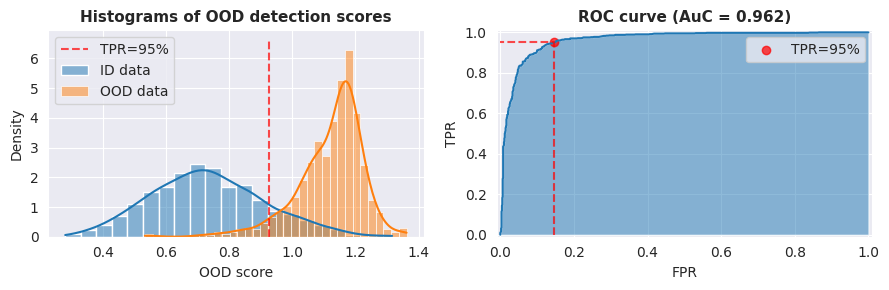

<Figure size 640x480 with 0 Axes>

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib.pyplot as plt
import numpy as np

from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()
# save the figure 
plt.savefig("nmf_concepts_viz_benchmark_imagenet.png")

In [ ]:
# do some analysis on the hyperparameter n_components 
reconstruction_errors = []
for i in range(1, 20):
    print(" --------- Fitting the model with ", i, " components ------------")
    detector = NMF_CONCEPTS_VIZ(model=model, n_components=i, separate_classes=[0])
    detector.fit(fit_dataset=ds_fit, model=model, feature_layers_id=["avgpool"])
    for label, nmf_data in detector.nmf_models.items():
        nmf = nmf_data['nmf']
        U = nmf_data['U']
        V = nmf_data['V']
        features = nmf_data['features']
        features_reconstructed = np.dot(U, V)
        # Calculate the reconstruction error
        error_frobenius = np.linalg.norm(features - features_reconstructed, 'fro')
        norm_features = np.linalg.norm(features, 'fro')
        percentage_error = error_frobenius / norm_features * 100
        reconstruction_errors.append(percentage_error)
    print(f"Reconstruction error for {i} components: {percentage_error}")

    


    
    
    

In [6]:
# save the reconstruction errors in a json file 
import json
with open("reconstruction_errors.json", "w") as f:
    json.dump(reconstruction_errors, f)
    

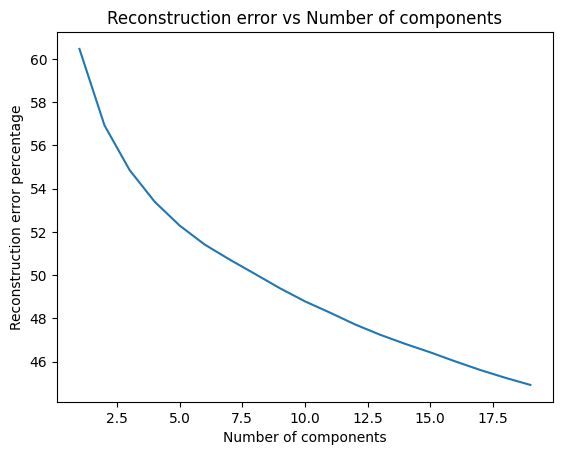

In [8]:



# plot the reconstruction errors 
plt.plot(list(range(1, 20)), reconstruction_errors)
plt.xlabel("Number of components")
plt.ylabel("Reconstruction error percentage")
plt.title("Reconstruction error vs Number of components")
plt.savefig("reconstruction_error_vs_n_components.png")
plt.show()
